NOTE: If some rows are commented out, it means that it is done for data protection reasons not to display unique id's of the posts. In the process of the work, these lines were used. Also some descriptive lines where id-s were displayed were eliminated from this file for security reasons but were a part of the work.

# Importing necessary packages

In [1]:
import pandas as pd
import numpy as np
import copy
import json
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from nltk.metrics.agreement import AnnotationTask

# Data Preparation

## Initial investigation and preparation

In [2]:
#READING IN DATA FROM FILES
GAD0_0 = pd.read_json('Reddit_GAD0_0.json', lines = True)
GAD0_1 = pd.read_json('Reddit_GAD0_1.json', lines = True)
GAD1_0 = pd.read_json('Reddit_GAD1_0.json', lines = True)
GAD1_1 = pd.read_json('Reddit_GAD1_1.json', lines = True)
GAD2_0 = pd.read_json('Reddit_GAD2_0.json', lines = True)
GAD2_1 = pd.read_json('Reddit_GAD2_1.json', lines = True)
GAD3_0 = pd.read_json('Reddit_GAD3_0.json', lines = True)
GAD3_1 = pd.read_json('Reddit_GAD3_1.json', lines = True)
GAD4_0 = pd.read_json('Reddit_GAD4_0.json', lines = True)
GAD4_1 = pd.read_json('Reddit_GAD4_1.json', lines = True)

***Annotator 1 dataset***

In [3]:
GAD0 = GAD0_0.append([GAD1_0, GAD2_0, GAD3_0, GAD4_0])
#EXAMPLE PRINT
#GAD0.head()

In [4]:
#PREPARE ANNOTATOR 1 DATASET WITH NONE TYPES IN LABEL, NOTE COLUMN

#SEPARATE CONTENT COLUMN INTO TWO COLUMNS: UNIQUE_ID AND TEXT
GAD0['unique_id'] = GAD0.content.str.split('\n', expand = True)[0]
GAD0['text'] = GAD0.content.str.split('\n',1, expand = True)[1]

GAD0['label_1'] = GAD0['annotation'].map(lambda x: x if x == None else x['labels'])
GAD0['note_1'] = GAD0['annotation'].map(lambda x: x if x == None else x['note'])

#DROP UNNECESSARY COLUMNS
GAD0 = GAD0.drop(['content', 'annotation', 'extras', 'metadata'], axis = 1)

#HAVE A LOOK AT THE FINAL DATAFRAME
#GAD0.head()

***Annotator 2 dataset***

In [5]:
GAD1 = GAD0_1.append([GAD1_1, GAD2_1, GAD3_1, GAD4_1])
#EXAMPLE PRINT
#GAD1.head()

In [6]:
#PREPARE ANNOTATOR 2 DATASET WITH NONE TYPES IN LABEL, NOTE COLUMN

#SEPARATE CONTENT COLUMN INTO TWO COLUMNS: UNIQUE_ID AND TEXT
GAD1['unique_id'] = GAD1.content.str.split('\n', expand = True)[0]
GAD1['text'] = GAD1.content.str.split('\n',1, expand = True)[1]

GAD1['label_2'] = GAD1['annotation'].map(lambda x: x if x == None else x['labels'])
GAD1['note_2'] = GAD1['annotation'].map(lambda x: x if x == None else x['note'])

#DROP UNNECESSARY COLUMNS
GAD1 = GAD1.drop(['content', 'annotation', 'extras', 'metadata'], axis = 1)

#HAVE A LOOK AT THE FINAL DATAFRAME
#GAD1.head()

Eliminating datapoints which have been multi-labelled -> annotation guideline indicates that each datapoint should have one label

In [7]:
#Transform dataframes into lists
GAD0_list = GAD0.values.tolist()
GAD1_list = GAD1.values.tolist()

In [8]:
#Eliminate rows with multiple labels
new_GAD0 = []

for row in GAD0_list:
  if row[2] == None:
    new_GAD0.append(row)
  elif len(row[2]) == 0:
    new_GAD0.append(row)
  elif len(row[2]) == 1: 
    new_GAD0.append(row)

len(new_GAD0)

484

In [9]:
#Eliminate rows with multiple labels
new_GAD1 = []

for row in GAD1_list:
  if row[2] == None:
    new_GAD1.append(row)
  elif len(row[2]) == 0:
    new_GAD1.append(row)
  elif len(row[2]) == 1: 
    new_GAD1.append(row)

len(new_GAD1)

484

In [10]:
#transform back into dataframes
new_GAD0_df = pd.DataFrame(new_GAD0)
new_GAD1_df = pd.DataFrame(new_GAD1)

In [11]:
#lists to string
new_GAD0_df[2] = new_GAD0_df[2].apply(lambda x: x if x == None else ','.join(map(str, x))) #or len(x) == 0 
new_GAD1_df[2] = new_GAD1_df[2].apply(lambda x: x if x == None else ','.join(map(str, x))) #or len(x) == 0 

In [12]:
#new_GAD0_df[2].value_counts()

In [13]:
#new_GAD1_df[2].value_counts()

In [14]:
new_GAD0_df = new_GAD0_df.rename(columns = {0: 'unique_id', 1: 'text', 2: 'label_1', 3: 'note_1'})
new_GAD1_df = new_GAD1_df.rename(columns = {0: 'unique_id', 1: 'text', 2: 'label_1', 3: 'note_1'})

Merging two annotator dataframes into one

In [15]:
df_both_annotators_new = pd.merge(new_GAD0_df, new_GAD1_df, on=['unique_id', 'text'], how='inner')
#df_both_annotators_new.head()

In [16]:
#SOME LABELS ARE OF NONE TYPE
#df_both_annotators_new[df_both_annotators_new['label_1_x'].isna()]

In [17]:
#SOME LABELS ARE OF NONE TYPE
#df_both_annotators_new[df_both_annotators_new['label_1_y'].isna()]

In [18]:
#Which rows have empty labels?
#df_both_annotators_new[df_both_annotators_new.astype(str)['label_1_x'] == '']

In [19]:
#Which rows have empty labels?
#df_both_annotators_new[df_both_annotators_new.astype(str)['label_1_y'] == '']

In [20]:
#replacing empty string with NaN
df_both_annotators_new['label_1_x'] = df_both_annotators_new['label_1_x'].replace('', np.nan)
df_both_annotators_new['label_1_y'] = df_both_annotators_new['label_1_y'].replace('', np.nan)

In [21]:
df_both_annotators_new = df_both_annotators_new.where(pd.notnull(df_both_annotators_new), None)

Word cloud

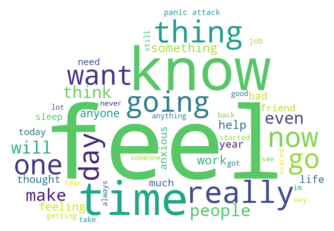

In [22]:
#https://towardsdatascience.com/create-word-cloud-into-any-shape-you-want-using-python-d0b88834bc32

text = " ".join(review for review in df_both_annotators_new.text)
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

mask = np.array(Image.open('cloud2.jpg'))
wc = WordCloud(
               mask=mask, background_color="white",
               max_words=50, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0])
wc.generate(text)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

## Cohen's Kappa

In [23]:
#TRANSFORMING ANNOTATORS' LABELS INTO LISTS AND MAKING THEM INTO BINARY FORM
labels_ann1 = list(df_both_annotators_new['label_1_x'])
labels_ann2 = list(df_both_annotators_new['label_1_y'])

labels_ann1_encoded = []
labels_ann2_encoded = []


for x in labels_ann1:
  if x is not None:
    if 'Not Distorted' in x:
        labels_ann1_encoded.append('Not Distorted')
    elif len(x) == 0:
        labels_ann1_encoded.append(None)
    else:
      labels_ann1_encoded.append('Distorted')
  else:
      labels_ann1_encoded.append(None)

for x in labels_ann2:
  if x is not None:
    if 'Not Distorted' in x:
        labels_ann2_encoded.append('Not Distorted')
    elif len(x) == 0:
        labels_ann2_encoded.append(None)
    else:
      labels_ann2_encoded.append('Distorted')
  else:
      labels_ann2_encoded.append(None)

In [24]:
#TAKE A LOOK AT THE RESULT
#print(len(labels_ann1_encoded))
#print(labels_ann1_encoded)

#print(len(labels_ann2_encoded))
#print(labels_ann2_encoded)

In [25]:
#ADD LISTS TO DATASET AND LOOK AT THE RESULT
df_both_annotators_new['label_1_x_encoded'] = pd.Series(labels_ann1_encoded)
df_both_annotators_new['label_1_y_encoded'] = pd.Series(labels_ann2_encoded)
#df_both_annotators_new.head()

In [26]:
df_both_annotators_new['label_1_x_encoded'].value_counts()

Not Distorted    237
Distorted        230
Name: label_1_x_encoded, dtype: int64

In [27]:
df_both_annotators_new['label_1_y_encoded'].value_counts()

Not Distorted    232
Distorted        231
Name: label_1_y_encoded, dtype: int64

In [28]:
df_both_annotators_new['label_1_x'].value_counts()

Not Distorted               237
Catastrophizing             107
Arbitrary Inference          38
Labeling                     21
Overgeneralization           21
Personalization              18
Selective Abstraction        15
Black and White Thinking     10
Name: label_1_x, dtype: int64

In [29]:
df_both_annotators_new['label_1_y'].value_counts()

Not Distorted               232
Catastrophizing              89
Arbitrary Inference          41
Labeling                     30
Overgeneralization           27
Personalization              26
Selective Abstraction        15
Black and White Thinking      3
Name: label_1_y, dtype: int64

In [30]:
#I NEED TO FILTER OUT NULL VALUES IN ORDER TO CALCULATE COHEN'S KAPPA SCORE
proov_df = copy.deepcopy(df_both_annotators_new)
proov_df = proov_df[proov_df.label_1_x_encoded.notnull()]
proov_df = proov_df[proov_df.label_1_y_encoded.notnull()]

#CALCULATING THE KAPPA SCORE
cohen_kappa_score(proov_df['label_1_x_encoded'], proov_df['label_1_y_encoded'])

#https://towardsdatascience.com/inter-rater-agreement-kappas-69cd8b91ff75 -> FAIR AGREEMENT!

0.2384938039876655

In [31]:
proov_df_maatriks = copy.deepcopy(proov_df)
proov_df_maatriks = proov_df_maatriks.rename(columns={"label_1_x":"Annotator_1", "label_1_y":"Annotator_2", "label_1_x_encoded":"Annotator_1_binary", "label_1_y_encoded":"Annotator_2_binary"})

In [33]:
agreement_matrix_binary = pd.crosstab(proov_df_maatriks['Annotator_1_binary'], proov_df_maatriks['Annotator_2_binary'])

Confusion matrix for binary and multi-class

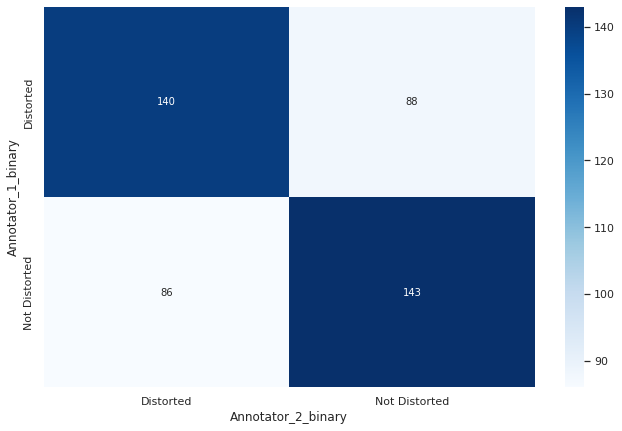

In [34]:
fig, ax = plt.subplots(figsize=(11,7))
ax = sns.heatmap(agreement_matrix_binary, cmap="Blues", annot=True, fmt='g')

In [35]:
#I TAKE OUT 'NOT DISTORTED' FROM LABEL1 AND LABEL2
without_not_distorted = df_both_annotators_new[df_both_annotators_new.label_1_x != 'Not Distorted']
without_not_distorted = without_not_distorted[without_not_distorted.label_1_y != 'Not Distorted']
#without_not_distorted.head()

In [36]:
#I CALCULATE AGREEMENT MATRIX WITH ONLY DISTORTED LABELS
agreement_matrix_without_not_distorted = pd.crosstab(without_not_distorted['label_1_x'], without_not_distorted['label_1_y']) 
agreement_matrix_without_not_distorted

label_1_y,Arbitrary Inference,Black and White Thinking,Catastrophizing,Labeling,Overgeneralization,Personalization,Selective Abstraction
label_1_x,,,,,,,
Arbitrary Inference,1,1,7,3,1,6,1
Black and White Thinking,1,0,0,0,1,0,1
Catastrophizing,10,0,40,3,8,5,4
Labeling,2,0,1,7,1,2,0
Overgeneralization,1,0,2,4,4,0,0
Personalization,5,0,2,4,0,3,1
Selective Abstraction,0,0,4,2,0,0,2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


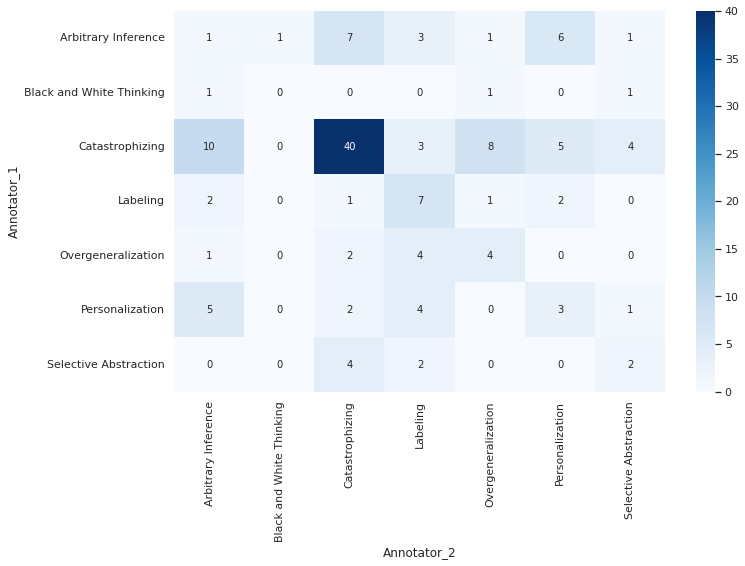

In [37]:
#I TAKE OUT 'NOT DISTORTED' FROM LABEL1 AND LABEL2
without_not_distorted = proov_df_maatriks[proov_df_maatriks.Annotator_1 != 'Not Distorted']
without_not_distorted = without_not_distorted[proov_df_maatriks.Annotator_2 != 'Not Distorted']
#I CALCULATE AGREEMENT MATRIX WITH ONLY DISTORTED LABELS
agreement_matrix_without_not_distorted = pd.crosstab(without_not_distorted['Annotator_1'], without_not_distorted['Annotator_2']) 
#I ILLUSTRATE THE RESULT
fig, ax = plt.subplots(figsize=(11,7))
ax = sns.heatmap(agreement_matrix_without_not_distorted, cmap="Blues", annot=True)

## Label binarization

In [38]:
#ANNOTATOR 1 
proov = copy.deepcopy(df_both_annotators_new)
s = proov['label_1_x'].explode()
hot_encoded = proov.join(pd.crosstab(s.index, s))
hot_encoded = hot_encoded.where(pd.notnull(hot_encoded), None)
#hot_encoded.head()

In [39]:
#ANNOTATOR 2
proov2 = copy.deepcopy(df_both_annotators_new)
s2 = proov2['label_1_y'].explode()
hot_encoded2 = proov2.join(pd.crosstab(s2.index, s2))
hot_encoded2 = hot_encoded2.where(pd.notnull(hot_encoded2), None)
#hot_encoded2.head()

In [40]:
#RENAME THE COLUMNS FOR BETTER UNDERSTANDING
hot_encoded2 = hot_encoded2.rename(columns={'Arbitrary Inference': 'Arbitrary Inference2', 'Black and White Thinking': 'Black and White Thinking2', 'Catastrophizing': 'Catastrophizing2', 'Labeling': 'Labeling2', 'Not Distorted': 'Not Distorted2', 'Overgeneralization': 'Overgeneralization2', 'Personalization': 'Personalization2', 'Selective Abstraction': 'Selective Abstraction2'})

Join Annotator 1 + Annotator 2 hot_encoded dataframes into one

In [41]:
hot_encoded_both = pd.merge(hot_encoded, hot_encoded2, on=['unique_id', 'text', 'note_1_x', 'note_1_y'], how = 'right')

hot_encoded_both.pop('label_1_x_encoded_y')
hot_encoded_both.pop('label_1_y_encoded_y')
hot_encoded_both.pop('label_1_x_y')
hot_encoded_both.pop('label_1_y_y')

hot_encoded_both = hot_encoded_both.rename(columns = {'label_1_x_x': 'label_1', 'label_1_y_x': 'label_2', 'label_1_x_encoded_x': 'binary label_1', 'label_1_y_encoded_x': 'binary label_2'})

In [42]:
#hot_encoded_both.head(3)

In [43]:
list_ = []
for idx, row in hot_encoded_both.iterrows():
  #print(frozenset([row['label_1']]))
  if row['label_1'] == None or len(row['label_1']) == 0:
    list_.append(('1', str(idx), frozenset(['NONE'])))
  elif row['label_1'] != None:
    list_.append(('1', str(idx), frozenset([row['label_1']])))
  if row['label_2'] == None or len(row['label_2']) == 0:
    list_.append(('2', str(idx), frozenset(['NONE'])))
  elif row['label_2'] != None:
    list_.append(('2', str(idx), frozenset([row['label_2']])))

labels = ['Arbitrary Inference', 'Black and White Thinking', 	'Catastrophizing',	'Labeling',	'Overgeneralization', 'Personalization',	'Selective Abstraction']
kappas = {'Arbitrary Inference':0, 'Black and White Thinking':0, 	'Catastrophizing':0,	'Labeling':0,	'Overgeneralization':0, 'Personalization':0,	'Selective Abstraction':0}

tuples2 = []

for label in labels:
  # iterate over the whole dataset and fill in the tuples
  for row in list_:
    rowList = list(row)
    if label in rowList[2]:
      rowList[2] = 1
    else:
      rowList[2] = 0
    tuples2.append(tuple(rowList))

  # initialize AnnotationTask
  task = AnnotationTask(data = tuples2)

  # get the Kappa value
  kappa = task.multi_kappa()
  kappas[label] = kappa
  tuples2 = []

kappas

{'Arbitrary Inference': -0.06335581442877611,
 'Black and White Thinking': -0.009853834784038963,
 'Catastrophizing': 0.25513833455513013,
 'Labeling': 0.2345274023531478,
 'Overgeneralization': 0.12285581826611097,
 'Personalization': 0.09569329845039273,
 'Selective Abstraction': 0.10494905385735236}

## Intersection VOL 1 - methodical intersection

In [44]:
#PREPARING NEW DATASET FOR INTERSECTION AS A COPY FROM ENCODED DATASET
intersection = copy.deepcopy(hot_encoded_both)
intersection.pop('binary label_1')
intersection.pop('binary label_2')

0          Distorted
1          Distorted
2          Distorted
3          Distorted
4      Not Distorted
           ...      
468    Not Distorted
469    Not Distorted
470    Not Distorted
471    Not Distorted
472    Not Distorted
Name: binary label_2, Length: 473, dtype: object

In [45]:
#APPLY INTERSECTION LOGIC TO LABELS
label_1s = list(intersection['label_1'])
label_2s = list(intersection['label_2'])

intersection_results = []

for idx, element in enumerate(label_1s):
  #print(element,label_2s[idx]) 
  if (element == None or len(element)==0) and label_2s[idx] != None:
    intersection_results.append(label_2s[idx])
  elif (label_2s[idx] == None or len(label_2s[idx])==0) and element != None:
    intersection_results.append(element)
  elif element == ['Not Distorted'] or label_2s[idx] == ['Not Distorted']:
    intersection_results.append('Not Distorted')
  #elif len(list(set(element) & set(label_2s[idx]))) > 0:
    #intersection_results.append(list(set(element) & set(label_2s[idx])))
  elif element == label_2s[idx]:
    intersection_results.append(element)
  elif element not in [None, "", ["Not Distorted"]] and label_2s[idx] not in [None, "", ["Not Distorted"]]:
    intersection_results.append('Not Distorted')

In [46]:
#HAVE A LOOK AT THE RESULTS
#print(label_1s)
#print(label_2s)
#print(intersection_results)
print(len(intersection_results))

473


In [47]:
#ADD THE INTERSECTION LABELS TO THE DATASET AND REMOVE UNNECESSARY COLUMNS
intersection['intersection_label'] = intersection_results
intersection_clean = intersection[['unique_id', 'text', 'label_1', 'label_2', 'intersection_label']]
#intersection_clean.head()

In [48]:
#HAVE A LOOK AT THE LABEL DISTRIBUTION FOR INTERSECTION DATASET
intersection_clean['intersection_label'].apply(lambda x: str(x)).value_counts()

Not Distorted               409
Catastrophizing              43
Labeling                      9
Overgeneralization            4
Personalization               4
Selective Abstraction         2
Arbitrary Inference           1
Black and White Thinking      1
Name: intersection_label, dtype: int64

# Intersection VOL2 - all or nothing intersection

In [49]:
intersection_2_test = copy.deepcopy(intersection)
intersection_2_test = intersection_2_test[['text', 'label_1', 'label_2']]

label_1s = list(intersection['label_1'])
label_2s = list(intersection['label_2'])

intersection_results = []

for idx, element in enumerate(label_1s):
  if element == None and label_2s[idx] != None:
    intersection_results.append([intersection_2_test['text'].loc[idx], label_2s[idx]])
  elif element != None and label_2s[idx] == None:
    intersection_results.append([intersection_2_test['text'].loc[idx], element])
  elif element == label_2s[idx]:
    intersection_results.append([intersection_2_test['text'].loc[idx], element])


In [50]:
intersection_df = pd.DataFrame(intersection_results, columns = ['text', 'label'])
intersection_df.head()

,text,label
0,I'm sure most people probably figured this is ...,Catastrophizing
1,I've started to realise my nausea is mostly ca...,Not Distorted
2,Every single day that I get my work done witho...,Not Distorted
3,For a long long time I have found it difficult...,Not Distorted
4,I’m sorry. I know it hurts. I know the pain of...,Not Distorted


In [51]:
intersection_df['label'].value_counts()

Not Distorted               152
Catastrophizing              43
Labeling                      9
Overgeneralization            4
Personalization               4
Selective Abstraction         2
Arbitrary Inference           1
Black and White Thinking      1
Name: label, dtype: int64

# Data Preprocessing - Intersection VOL 1

In [52]:
distortions = ['Overgeneralization', 'Personalization', 'Selective Abstraction', 'Arbitrary Inference', 'Black and White Thinking']

In [53]:
intersection_clean['intersection_label_new'] = intersection_clean['intersection_label'].apply(lambda x: 'Other distortion' if x in distortions else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [54]:
intersection_clean['intersection_label_new'].value_counts()

Not Distorted       409
Catastrophizing      43
Other distortion     12
Labeling              9
Name: intersection_label_new, dtype: int64

# Data Preprocessing - Intersection VOL 2

In [55]:
distortions = ['Overgeneralization', 'Personalization', 'Selective Abstraction', 'Arbitrary Inference', 'Black and White Thinking']

In [56]:
intersection_df['label_new'] = intersection_df['label'].apply(lambda x: 'Other distortion' if x in distortions else x)

In [57]:
intersection_df['label_new'].value_counts()

Not Distorted       152
Catastrophizing      43
Other distortion     12
Labeling              9
Name: label_new, dtype: int64

In [58]:
#REMOVAL OF LINE BREAKS
intersection_df['text'] = intersection_df['text'].replace('\n',' ', regex=True)

In [59]:
#PUT UNION BINARY LABEL AS A SEPARATE COLUMN TO THE DATASET
intersection_labels_list = list(intersection_df['label_new'])
intersection_labels_list_binary = []

for label in intersection_labels_list:
  if label == 'Not Distorted':
    intersection_labels_list_binary.append(0)
  else:
    intersection_labels_list_binary.append(1)

intersection_df['binary'] = pd.Series(intersection_labels_list_binary)

In [60]:
#PUT UNION BINARY LABEL AS A SEPARATE COLUMN TO THE DATASET
intersection_labels_list = list(intersection_df['binary'])
intersection_labels_list_binary = []

for label in intersection_labels_list:
  if label == 0:
    intersection_labels_list_binary.append('Not Distorted')
  else:
    intersection_labels_list_binary.append('Distorted')

intersection_df['label_binary'] = pd.Series(intersection_labels_list_binary)

In [61]:
distortions = ['Overgeneralization', 'Personalization', 'Selective Abstraction', 'Arbitrary Inference', 'Black and White Thinking', 'Labeling']

In [62]:
intersection_df['label_new_2'] = intersection_df['label'].apply(lambda x: 'Other distortion' if x in distortions else x)

In [63]:
intersection_df['label_new_2'].value_counts()

Not Distorted       152
Catastrophizing      43
Other distortion     21
Name: label_new_2, dtype: int64

In [64]:
#Save union dataset as JSON
#intersection_df.to_json('intersection_df.json', orient="records", lines = True)